notebook driller lidtog nogle af parkerne der drillede mest var de her under grupper af trame.

Trame vtk
>pip install --upgrade trame-vtk

Trame vutify
>pip install --upgrade trame-vuetify

In [119]:
# code from : https://mne.tools/dev/auto_tutorials/preprocessing/70_fnirs_processing.html#converting-from-raw-intensity-to-optical-density
from itertools import compress

import matplotlib.pyplot as plt
import numpy as np

from mne.datasets import sample
import mne
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    print_dir_tree,
    make_report,
    find_matching_paths,
    get_entity_vals,
)
sessions = get_entity_vals("./Rob Luke Tapping dataset", "session")
datatype = "nirs"
extension = [".snirf"]
bids_paths = find_matching_paths("./Rob Luke Tapping dataset", datatypes=datatype, extensions=extension)
bids_paths[0]

BIDSPath(
root: Rob Luke Tapping dataset
datatype: nirs
basename: sub-01_task-tapping_nirs.snirf)

In [118]:
raw = read_raw_bids(bids_paths[0])

Loading c:\Users\adamb\OneDrive\Uni\sem4\fagprojekt\Rob Luke Tapping dataset\sub-01\nirs\sub-01_task-tapping_nirs.snirf
Reading events from Rob Luke Tapping dataset\sub-01\nirs\sub-01_task-tapping_events.tsv.
Reading channel info from Rob Luke Tapping dataset\sub-01\nirs\sub-01_task-tapping_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info


In [121]:
print(raw.info["subject_info"])

{'his_id': 'sub-01', 'age': '34', 'sex': 1, 'hand': 0}


In [122]:
raw_intensity = raw.copy().pick(picks="all")

In [123]:
# %%
# We attribute meaningful names to the triggers, and we include information about duration of each stimulus. We also remove trigger code 15.0 because irrelevant.#
raw_intensity.annotations.set_durations(5)
#raw_intensity.annotations.rename(
#    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
#)
unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.delete(unwanted)


In [124]:
# %%
# We validate location of sources and detectors. We also visualize the sensor locations on the scalp.#
subjects_dir = mne.datasets.sample.data_path() / "subjects"

brain = mne.viz.Brain(
    "fsaverage", subjects_dir=subjects_dir, background="w", cortex="0.5"
)
brain.add_sensors(
    raw_intensity.info,
    trans="fsaverage",
    fnirs=["channels", "pairs", "sources", "detectors"],
)
brain.show_view(azimuth=20, elevation=60, distance=400)


Channel types::	fnirs_cw_amplitude: 56


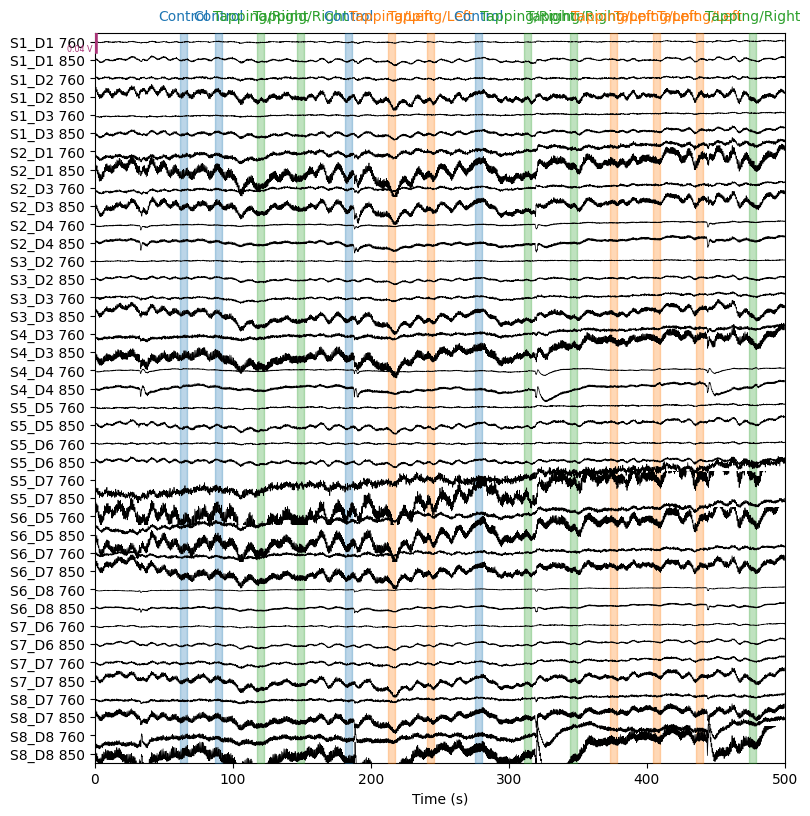

Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


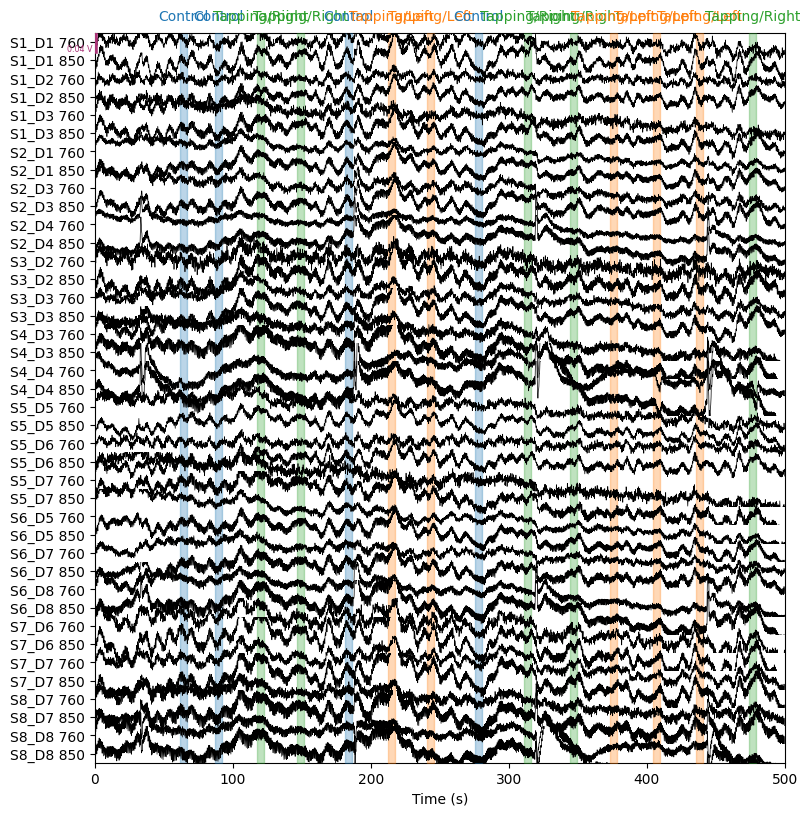

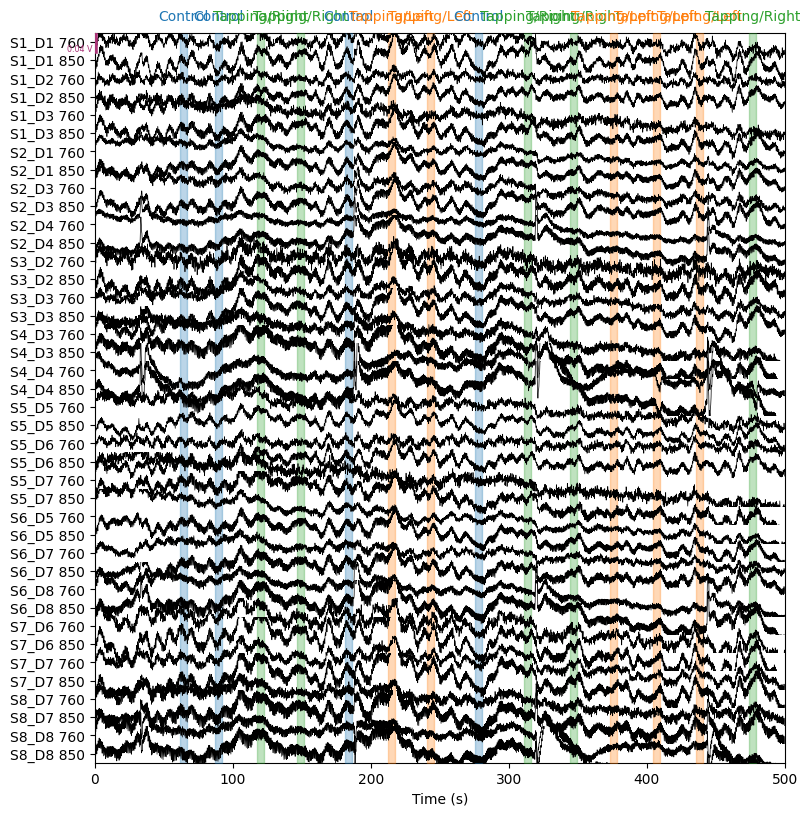

In [125]:
# %%
# We remove channels that are too close to each other. We then convert the intensity data to optical density data.#
picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks=picks
)
raw_intensity.pick(picks[dists > 0.01])
raw_intensity.plot(
    n_channels=len(raw_intensity.ch_names), duration=500, show_scrollbars=False
)

raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_od.plot(n_channels=len(raw_od.ch_names), duration=500, show_scrollbars=False)

In [126]:
# %%
# We evaluate the scalp coupling index (SCI) to identify bad channels and remove if necessary.#
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots(layout="constrained")
ax.hist(sci)
ax.set(xlabel="Scalp Coupling Index", ylabel="Count", xlim=[0, 1])

[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

In [127]:
# %%
# Example marked SCI's with less than 0.5 as bad channels. Maybe we should follow?#

raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))

# We might want to inspect the raw data after removing bad channels.#

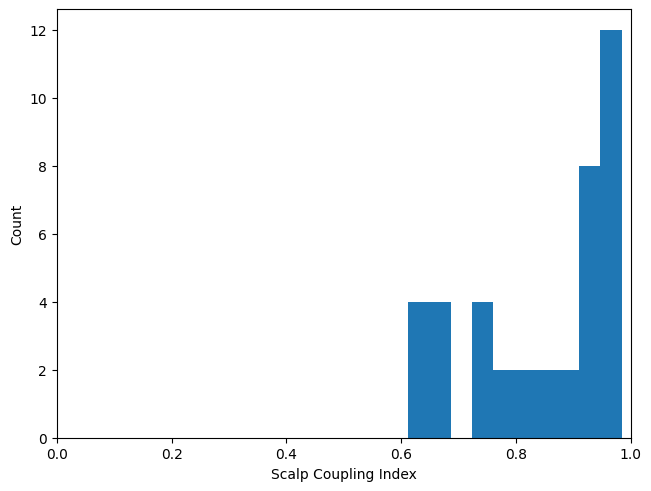

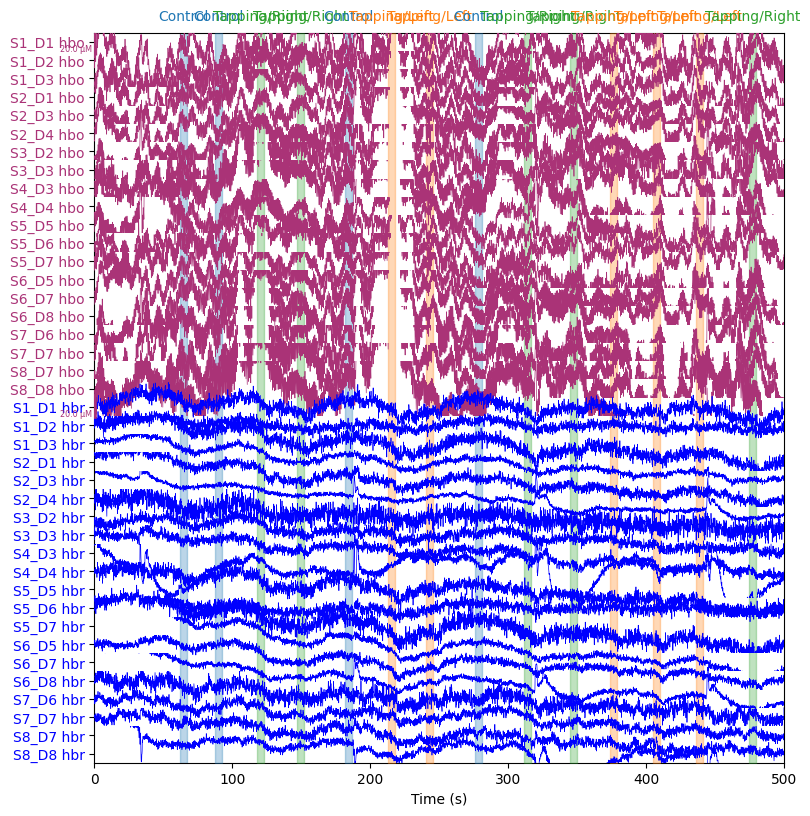

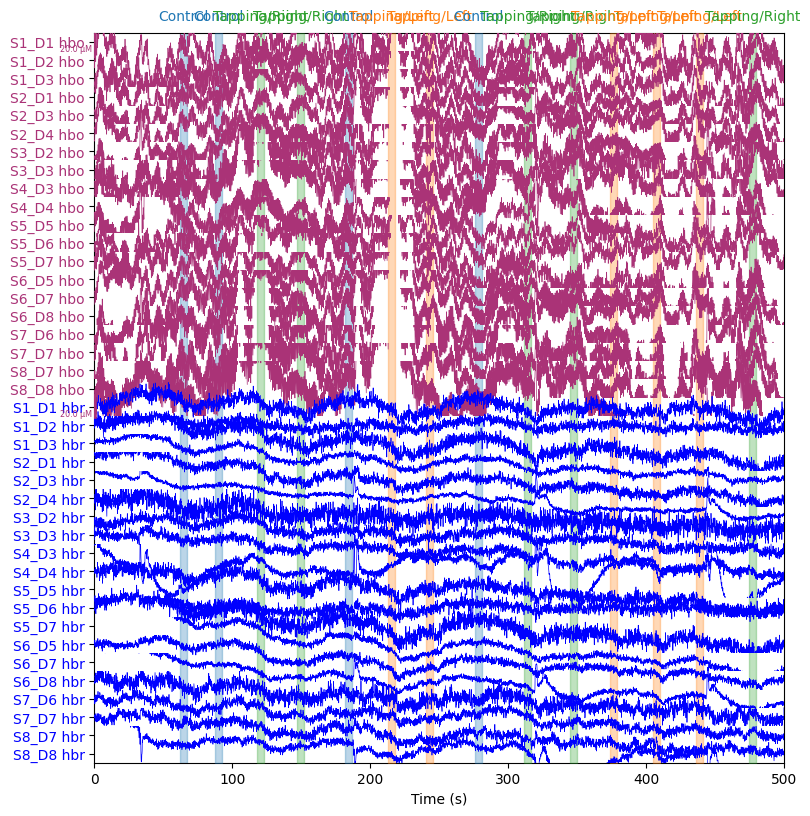

In [128]:
# %%
# We convert from optical density to haemoglobin concentration.#

raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=500, show_scrollbars=False)


In [129]:
# %%

# We filter the data to remove heart rate and respiration artefacts.#

raw_haemo_unfiltered = raw_haemo.copy()
raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)
for when, _raw in dict(Before=raw_haemo_unfiltered, After=raw_haemo).items():
    fig = _raw.compute_psd().plot(
        average=True, amplitude=False, picks="data", exclude="bads"
    )
    fig.suptitle(f"{when} filtering", weight="bold", size="x-large")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Effective window size : 262.144 (s)
Effective window size : 262.144 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
c:\Users\adamb\Fagprojekt\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\adamb\Fagprojekt\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: ['Control', 'Tapping/Left', 'Tapping/Right']


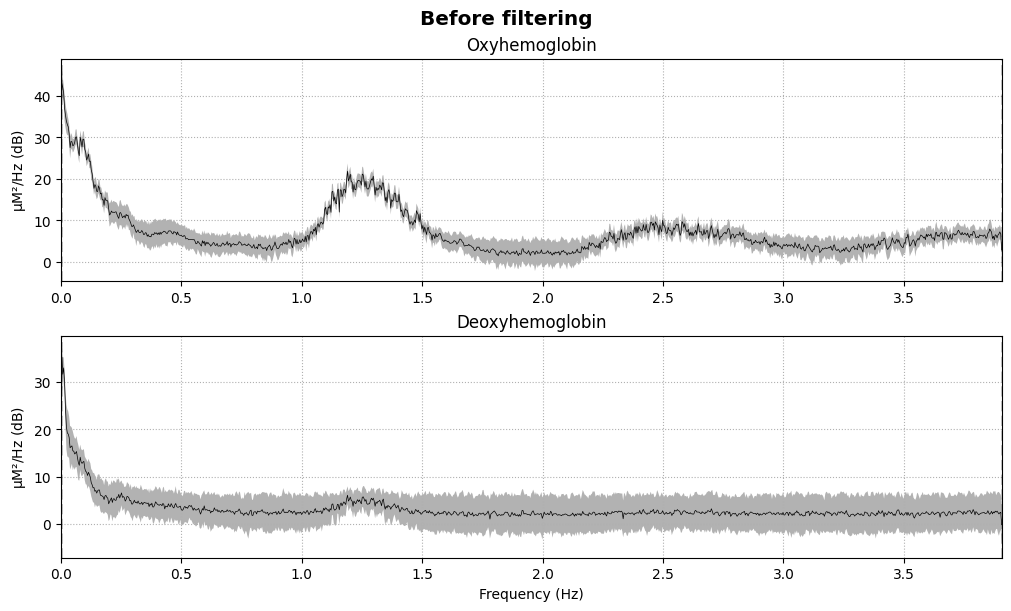

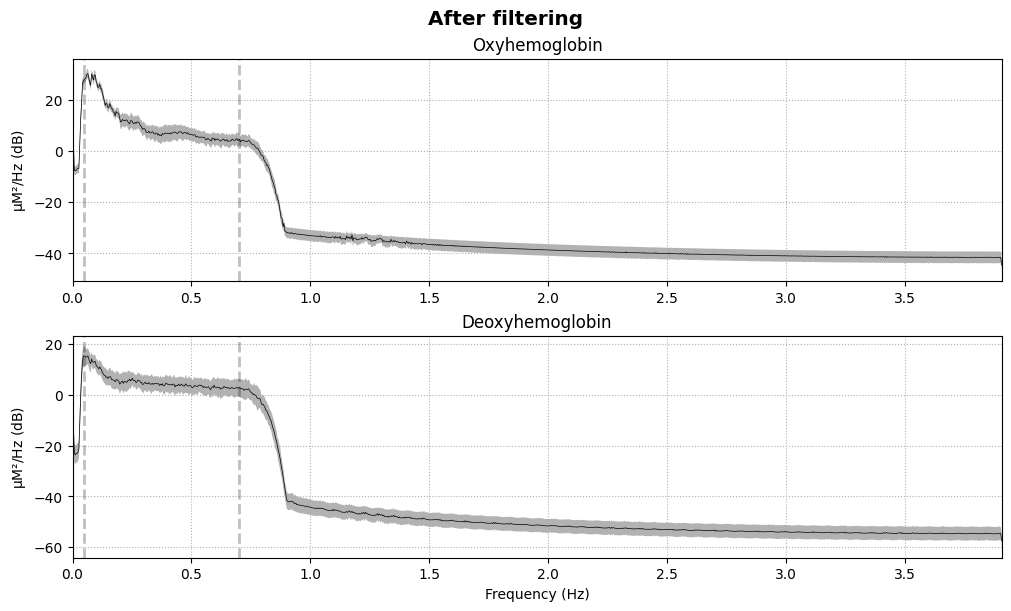

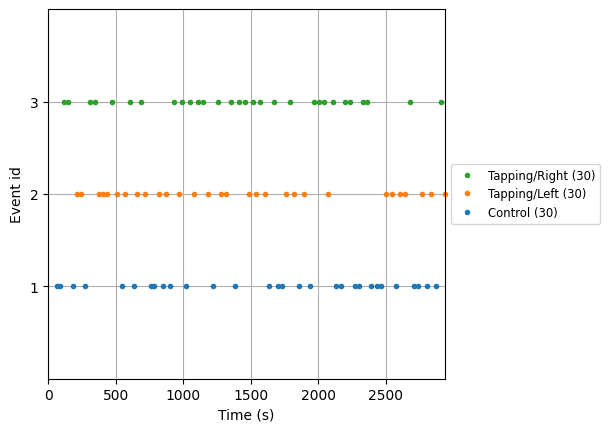

In [130]:
# %%
# We extract epochs from the data.#
events, event_dict = mne.events_from_annotations(raw_haemo)
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info["sfreq"])

Not setting metadata
90 matching events found
Setting baseline interval to [-4.992, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 157 original time points ...
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S3_D3 hbo', 'S4_D4 hbo', 'S7_D6 hbo', 'S7_D7 hbo', 'S8_D8 hbo']


    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S6_D8 hbo', 'S8_D8 hbo']
6 bad epochs dropped


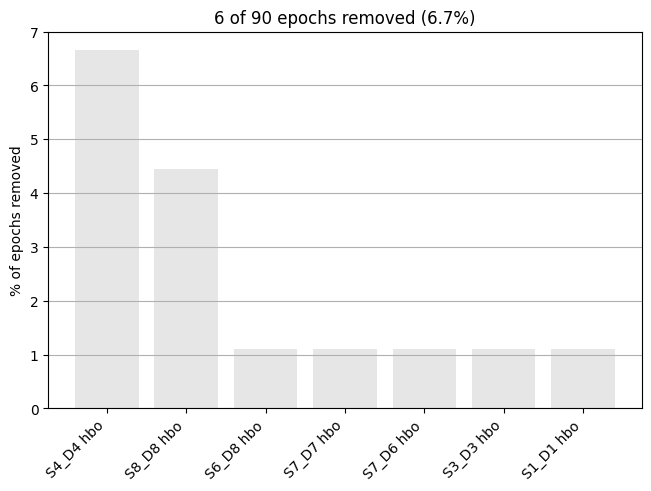

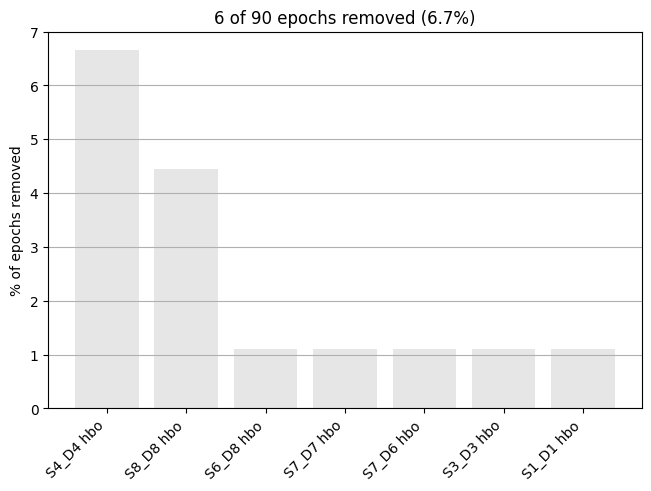

In [131]:
# %%

# We define range of epochs, rejection criteria, baseline correction, and extract the epochs.#
# We also visualize the drop log to see if any epochs were dropped.#

reject_criteria = dict(hbo=80e-6)
tmin, tmax = -5, 15

epochs = mne.Epochs(
    raw_haemo,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    reject=reject_criteria,
    reject_by_annotation=True,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)
epochs.plot_drop_log()

Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


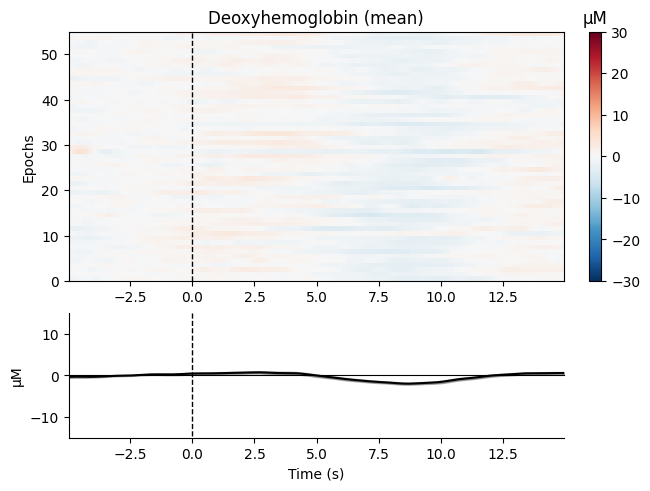

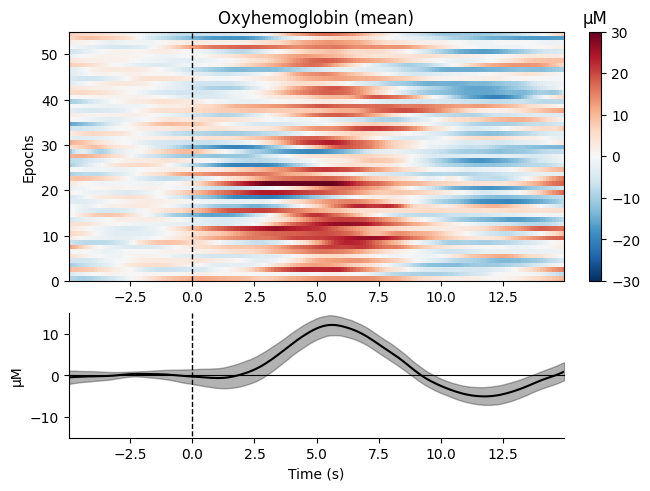

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [132]:
# %%
# We visualize the epochs. Specifically consistency of responses across trials.#
epochs["Tapping"].plot_image(
    combine="mean",
    vmin=-30,
    vmax=30,
    ts_args=dict(ylim=dict(hbo=[-15, 15], hbr=[-15, 15])),
)


Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


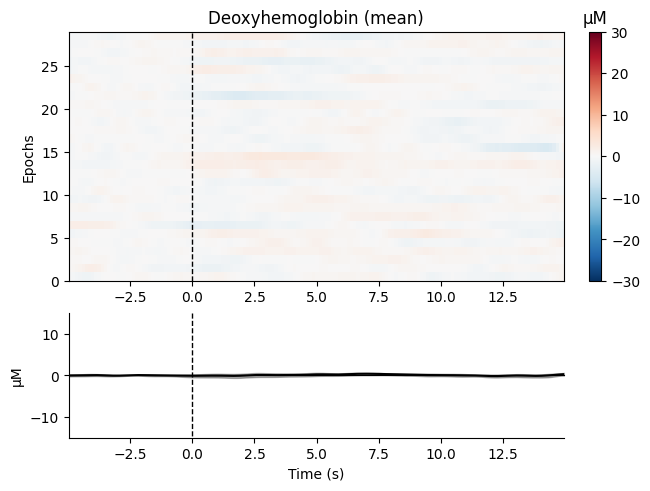

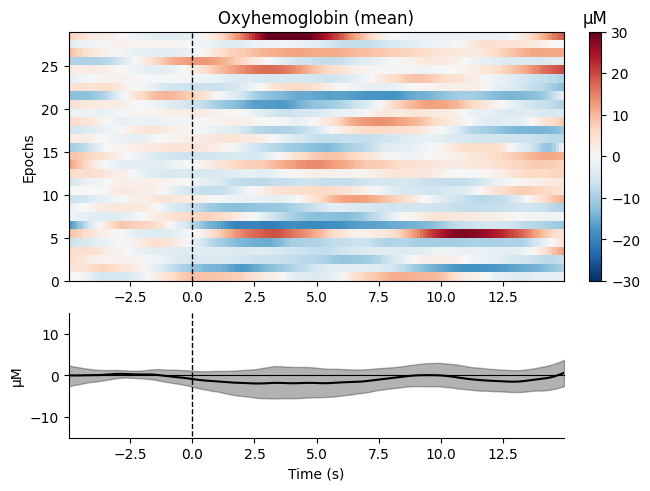

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [133]:
# %%
# We visualize the epochs.#
epochs["Control"].plot_image(
    combine="mean",
    vmin=-30,
    vmax=30,
    ts_args=dict(ylim=dict(hbo=[-15, 15], hbr=[-15, 15])),
)


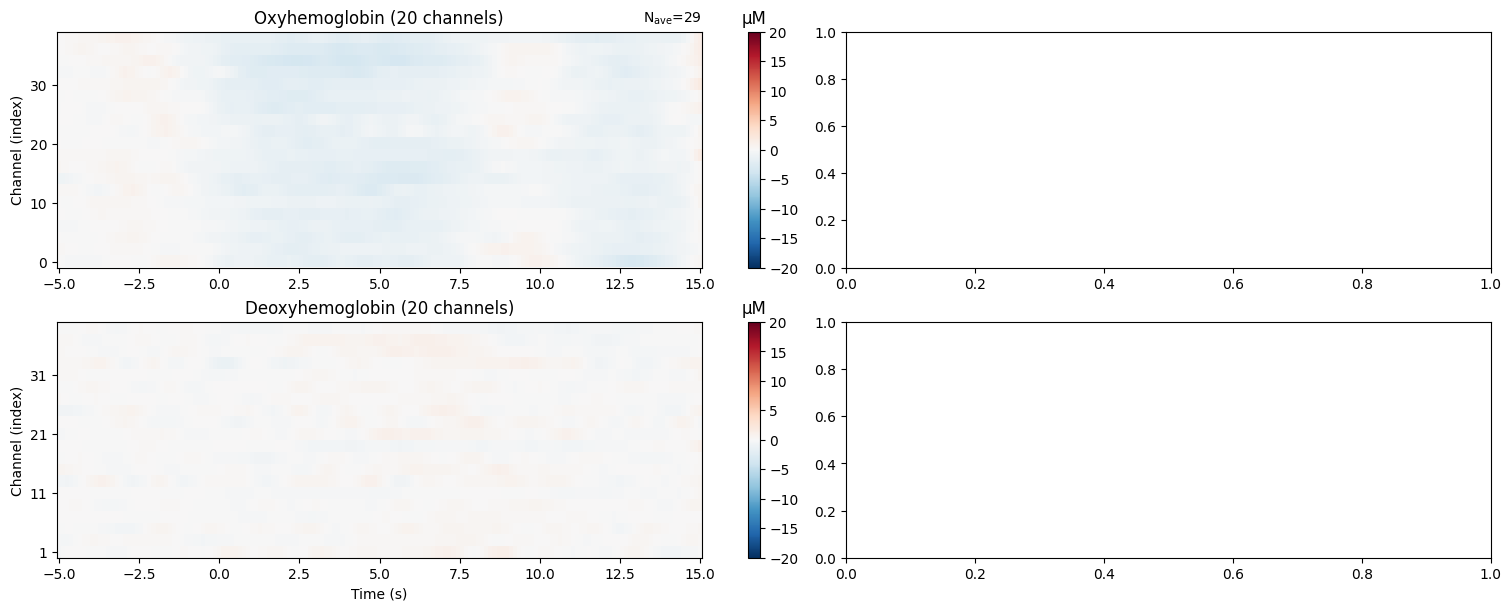

<Figure size 640x480 with 0 Axes>

In [134]:
# %%
# We visualize the epochs. Specifically consistency of responses across channels.#
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), layout="constrained")
clims = dict(hbo=[-20, 20], hbr=[-20, 20])
epochs["Control"].average().plot_image(axes=axes[:, 0], clim=clims)
epochs["Tapping"].average().plot_image(axes=axes[:, 1], clim=clims)
for column, condition in enumerate(["Control", "Tapping"]):
    for ax in axes[:, column]:
        ax.set_title(f"{condition}: {ax.get_title()}")


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


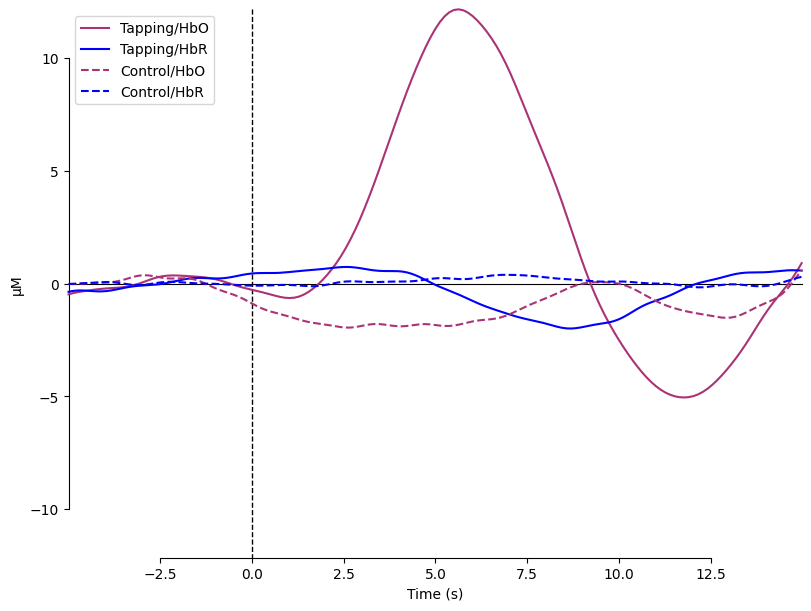

[<Figure size 800x600 with 1 Axes>]

In [135]:
# %%
# We visualize the epochs. This plots a standard fNIRS response image.#
evoked_dict = {
    "Tapping/HbO": epochs["Tapping"].average(picks="hbo"),
    "Tapping/HbR": epochs["Tapping"].average(picks="hbr"),
    "Control/HbO": epochs["Control"].average(picks="hbo"),
    "Control/HbR": epochs["Control"].average(picks="hbr"),
}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO="#AA3377", HbR="b")
styles_dict = dict(Control=dict(linestyle="dashed"))

mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)

No projector specified for this dataset. Please consider the method self.add_proj.


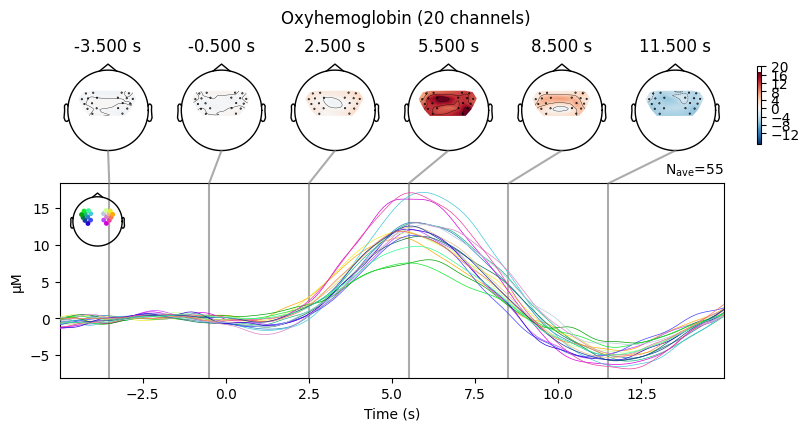

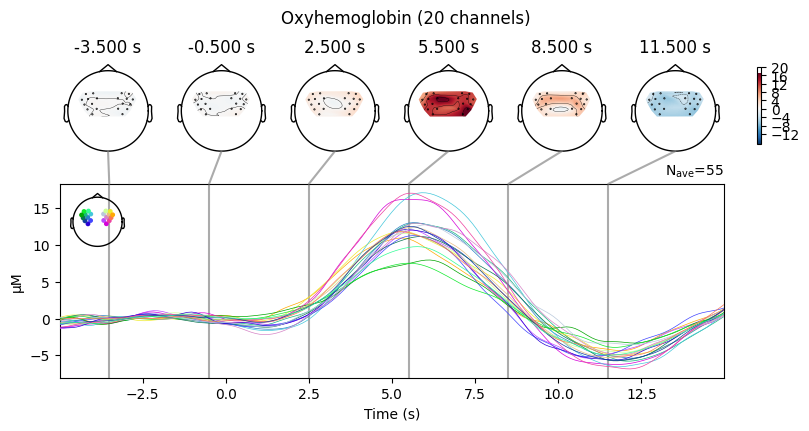

In [136]:
# %%
# Topographic representation of activity.#
times = np.arange(-3.5, 13.2, 3.0)
topomap_args = dict(extrapolate="local")
epochs["Tapping"].average(picks="hbo").plot_joint(
    times=times, topomap_args=topomap_args
)


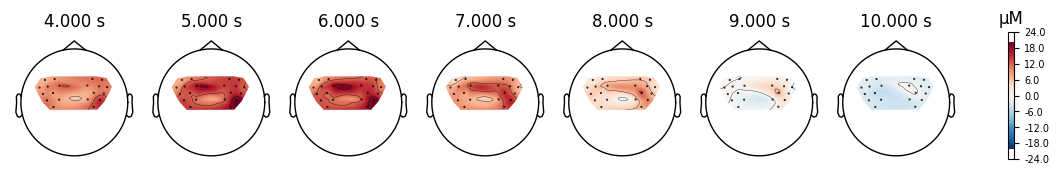

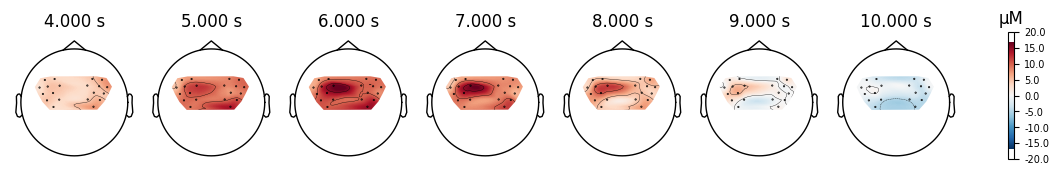

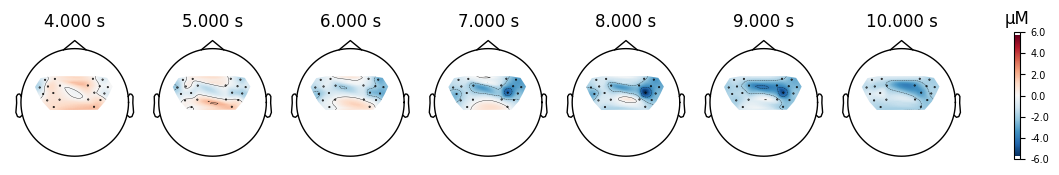

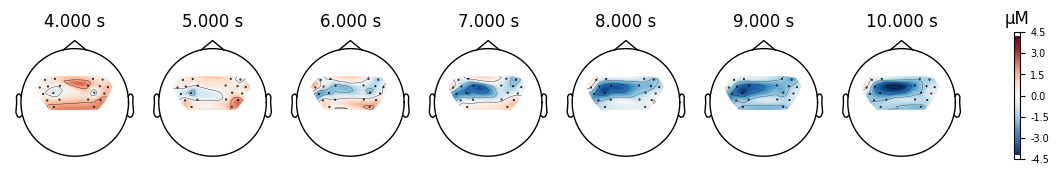

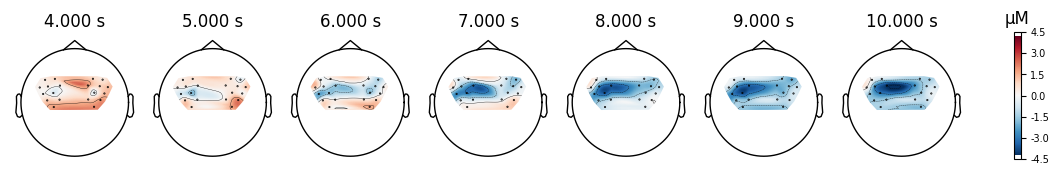

In [137]:
# %%
# We compare the topographic representation of activity between tapping left and right.#
times = np.arange(4.0, 11.0, 1.0)
epochs["Tapping/Left"].average(picks="hbo").plot_topomap(times=times, **topomap_args)
epochs["Tapping/Right"].average(picks="hbo").plot_topomap(times=times, **topomap_args)

epochs["Tapping/Left"].average(picks="hbr").plot_topomap(times=times, **topomap_args)
epochs["Tapping/Right"].average(picks="hbr").plot_topomap(times=times, **topomap_args)


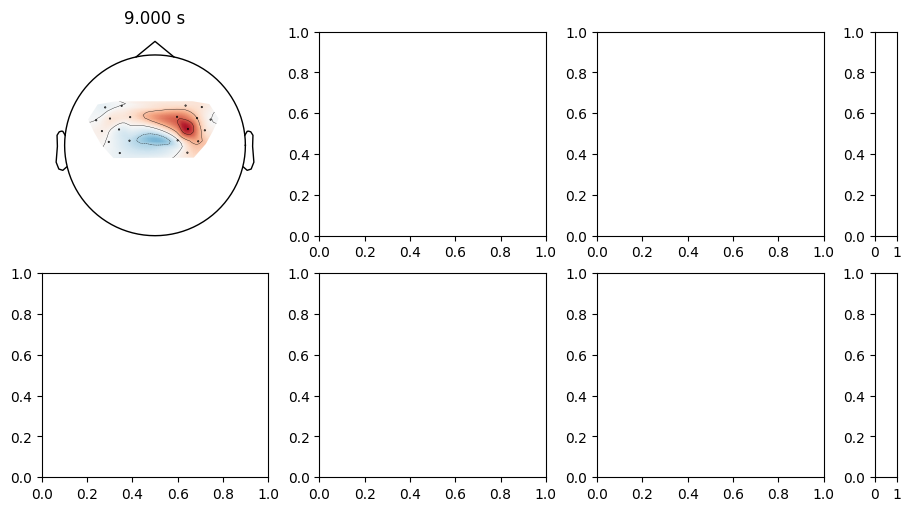

In [138]:
# %%
# We plot this comparison in a more compact way.
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    figsize=(9, 5),
    gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1]),
    layout="constrained",
)
vlim = (-8, 8)
ts = 9.0

evoked_left = epochs["Tapping/Left"].average()
evoked_right = epochs["Tapping/Right"].average()

evoked_left.plot_topomap(
    ch_type="hbo", times=ts, axes=axes[0, 0], vlim=vlim, colorbar=False, **topomap_args
)
evoked_left.plot_topomap(
    ch_type="hbr", times=ts, axes=axes[1, 0], vlim=vlim, colorbar=False, **topomap_args
)
evoked_right.plot_topomap(
    ch_type="hbo", times=ts, axes=axes[0, 1], vlim=vlim, colorbar=False, **topomap_args
)
evoked_right.plot_topomap(
    ch_type="hbr", times=ts, axes=axes[1, 1], vlim=vlim, colorbar=False, **topomap_args
)

evoked_diff = mne.combine_evoked([evoked_left, evoked_right], weights=[1, -1])

evoked_diff.plot_topomap(
    ch_type="hbo", times=ts, axes=axes[0, 2:], vlim=vlim, colorbar=True, **topomap_args
)
evoked_diff.plot_topomap(
    ch_type="hbr", times=ts, axes=axes[1, 2:], vlim=vlim, colorbar=True, **topomap_args
)

for column, condition in enumerate(["Tapping Left", "Tapping Right", "Left-Right"]):
    for row, chroma in enumerate(["HbO", "HbR"]):
        axes[row, column].set_title(f"{chroma}: {condition}")


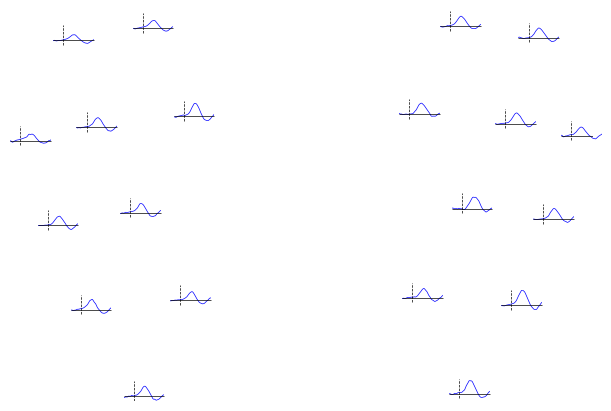

In [139]:
# %%
# We plot the topographic representation of activity across all conditions.#
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), layout="constrained")
mne.viz.plot_evoked_topo(
    epochs["Left"].average(picks="hbo"), color="b", axes=axes, legend=False
)
mne.viz.plot_evoked_topo(
    epochs["Right"].average(picks="hbo"), color="r", axes=axes, legend=False
)

# Tidy the legend:
leg_lines = [line for line in axes.lines if line.get_c() == "b"][:1]
leg_lines.append([line for line in axes.lines if line.get_c() == "r"][0])
fig.legend(leg_lines, ["Left", "Right"], loc="lower right")

In [140]:
from sklearn.neural_network import MLPClassifier
t = 5.0
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=0)
X = epochs.copy().crop(t, t+2).get_data().mean(axis=-1)
X = X.reshape(len(X), -1)
x_train, x_test = X[:40], X[40:]
# 0 for control, 1 for tapping
y = epochs.events[:, 2] - 1
y_train, y_test = y[:40], y[40:]
for i in range(len(y)):
    if y[i] == 2:
        y[i] = 1
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = (y_test == y_pred).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.61


C:\Users\adamb\AppData\Local\Temp\ipykernel_36532\3976619005.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.copy().crop(t, t+2).get_data().mean(axis=-1)
